# Deep Learning
***Name***: *Aviv Nutovitz*

### Import Packages

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import os, time

Using TensorFlow backend.


### Model Architecture

In [0]:
class LeNet:
  """
  net_type_dict - dictionary with the type of regularization and the reuquired parameters: 
  1. {"weight_decay":"0.001"} (L2 norm)
  2. {"batch_normalization":"0.9"}
  3. {"with_dropout":"0.25"}
  4. {"without_regularization":"none"}
  """
  @staticmethod
  def build(numChannels, imgRows, imgCols, numClasses, net_type_dict, activation="relu"):
    # initialize the model
    model = Sequential()
    # parameters for the diffrent types of regularization
    type_key = next(iter(net_type_dict))
    type_value = net_type_dict[type_key]
    input_shape = (imgRows, imgCols, numChannels)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      input_shape = (numChannels, imgRows, imgCols)

    # define the first set of CONV => ACTIVATION => POOL layers
    if type_key == 'weight_decay': 
      model.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), padding="same", kernel_regularizer=regularizers.l2(float(type_value)), input_shape=input_shape))
    else:
      model.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), padding="same",input_shape=input_shape))
    model.add(Activation(activation))

    if type_key =='batch_normalization':
      model.add(BatchNormalization(momentum=float(type_value)))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # define the second set of CONV => ACTIVATION => POOL layers
    if type_key == 'weight_decay': 
      model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), padding="same", kernel_regularizer=regularizers.l2(float(type_value))))
    else:
      model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), padding="same"))
      
    model.add(Activation(activation))
    if type_key == 'batch_normalization':
      model.add(BatchNormalization(momentum=float(type_value)))
      
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # define the first FC => ACTIVATION layers
    model.add(Flatten())
    if type_key == 'weight_decay':
      model.add(Dense(120, kernel_regularizer=regularizers.l2(float(type_value))))
    else:
      model.add(Dense(120))
     
    if type_key =='batch_normalization':
      model.add(BatchNormalization(momentum=float(type_value)))
      
    # define the secund FC => ACTIVATION layers
    if type_key == 'weight_decay':
      model.add(Dense(84, kernel_regularizer=regularizers.l2(float(type_value))))
    else:
      model.add(Dense(84))

    if type_key =='with_dropout':
      model.add(Dropout(rate=float(type_value), input_shape=(input_shape[0], input_shape[1], input_shape[2])))
    elif type_key =='batch_normalization':
      model.add(BatchNormalization(momentum=float(type_value)))

    model.add(Activation(activation))

    # define the second FC layer
    if type_key == 'weight_decay':
      model.add(Dense(numClasses, kernel_regularizer=regularizers.l2(float(type_value))))
    else:
      model.add(Dense(numClasses))

    # lastly, define the soft-max classifier
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

def build_model(net_type):
    model = LeNet.build(numChannels=1, imgRows=28, imgCols=28, numClasses=10, net_type_dict = net_type)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

### Data Preprocessing

In [0]:
def pre_prossecing():
  # Load the fashion-mnist pre-shuffled train data and test data
  print("[INFO] downloading Fashion MNIST...")
  ((train_data, train_labels), (test_data, test_labels)) = fashion_mnist.load_data()

  # if we are using "channels first" ordering, then reshape the
  # design matrix such that the matrix is:
  # num_samples x depth x rows x columns
  if K.image_data_format() == "channels_first":
    train_data = train_data.reshape((train_data.shape[0], 1, 28, 28))
    test_data = test_data.reshape((test_data.shape[0], 1, 28, 28))

  # otherwise, we are using "channels last" ordering, so the design
  # matrix shape should be: num_samples x rows x columns x depth
  else:
    train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
    test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

  # scale data to the range of [0, 1]
  train_data = train_data.astype("float32") / 255.0
  test_data = test_data.astype("float32") / 255.0

  # transform the training and testing labels into vectors in the
  # range [0, classes] -- this generates a vector for each label,
  # where the index of the label is set to `1` and all other entries
  # to `0`; in the case of MNIST, there are 10 class labels
  train_labels = np_utils.to_categorical(train_labels, 10)
  test_labels = np_utils.to_categorical(test_labels, 10)
  
  return (train_data, train_labels), (test_data, test_labels)

### Train Model and Plot Graphs:
- Train model
- Evaluate using test set
- Saving the model to be loaded for testing purposes

In [0]:
def train_type(net_type , train_data, train_labels, test_data, test_labels):
  # build & compile the model for the training
  model = build_model(net_type)
  
  checkpoint_path = "training_{}/cp.ckpt".format(next(iter(net_type)))
  checkpoint_dir = os.path.dirname(checkpoint_path)
  # create dir if not exsit
  !mkdir {checkpoint_dir}
  
  # Create checkpoint callback
  # EarlyStopping will stop training when accuracy hasn't improved for 5 epochs
  cp_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
  callbacks = [cp_callback, EarlyStopping(monitor='val_acc', patience=5, verbose=1, min_delta=1e-4)]
  
  # Measure training time
  t1 = time.time() 
  history = model.fit(train_data, train_labels, epochs=50, batch_size=128, verbose=1, validation_data=(test_data, test_labels), callbacks=callbacks)

  t2 = time.time()
  print("Total training time: %0.2fs" % (t2 - t1))
  
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy for {}'.format(next(iter(net_type))))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss for {}'.format(next(iter(net_type))))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
  ## return the saved model path
  return checkpoint_path
  

### Load model and check test final results

In [0]:
def test_type(net_type , test_data, test_labels, checkpoint_path):
  # build & compile the model for the training
  model = build_model(net_type)
 
  model.load_weights(checkpoint_path)
  loss,acc = model.evaluate(test_data, test_labels)
  print("Restored model, accuracy: {:5.2f}%".format(100*acc))
  print("------------------------Done test stage: {}------------------------".format(net_type))

In [0]:
# get the data fro the training
(train_data, train_labels), (test_data, test_labels) = pre_prossecing()

# pick one to the following types
type_1 = {"weight_decay":"0.001"}

type_2 = {"batch_normalization":"0.9"}

type_3 = {"with_dropout":"0.50"}

type_4 = {"without_regularization":"none"}


[INFO] downloading Fashion MNIST...


mkdir: cannot create directory ‘training_weight_decay’: File exists
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.8411 - acc: 0.7857 - val_loss: 0.6437 - val_acc: 0.8460

Epoch 00001: saving model to training_weight_decay/cp.ckpt
Epoch 2/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.5803 - acc: 0.8572 - val_loss: 0.5784 - val_acc: 0.8445

Epoch 00002: saving model to training_weight_decay/cp.ckpt
Epoch 3/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.5140 - acc: 0.8697 - val_loss: 0.5259 - val_acc: 0.8591

Epoch 00003: saving model to training_weight_decay/cp.ckpt
Epoch 4/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.4735 - acc: 0.8778 - val_loss: 0.4696 - val_acc: 0.8771

Epoch 00004: saving model to training_weight_decay/cp.ckpt
Epoch 5/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.4472 - acc: 

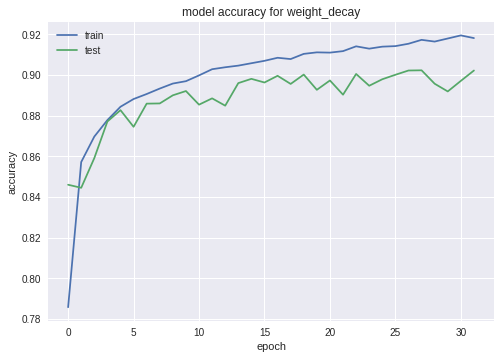

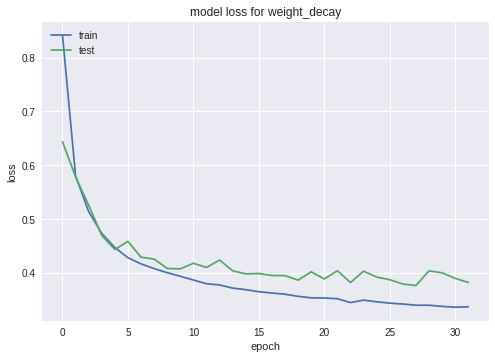

Model saved into: training_weight_decay/cp.ckpt


In [0]:
# train type_1 - weight_decay
checkpoint_path_type_1 = train_type(type_1, train_data, train_labels, test_data, test_labels)
print("Model saved into: {}".format(checkpoint_path_type_1))

In [0]:
# test type_1
test_type(type_1, test_data, test_labels, checkpoint_path_type_1)

10000/10000 [==============================] - 1s 95us/step
Restored model, accuracy: 90.22%
------------------------Done test stage: {'weight_decay': '0.001'}------------------------


mkdir: cannot create directory ‘training_batch_normalization’: File exists
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 161us/step - loss: 0.4182 - acc: 0.8552 - val_loss: 0.3413 - val_acc: 0.8760

Epoch 00001: saving model to training_batch_normalization/cp.ckpt
Epoch 2/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.2706 - acc: 0.9011 - val_loss: 0.2787 - val_acc: 0.8983

Epoch 00002: saving model to training_batch_normalization/cp.ckpt
Epoch 3/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.2365 - acc: 0.9136 - val_loss: 0.2813 - val_acc: 0.8952

Epoch 00003: saving model to training_batch_normalization/cp.ckpt
Epoch 4/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.2132 - acc: 0.9204 - val_loss: 0.2861 - val_acc: 0.8960

Epoch 00004: saving model to training_batch_normalization/cp.ckpt
Epoch 5/50
60000/60000 [==============================

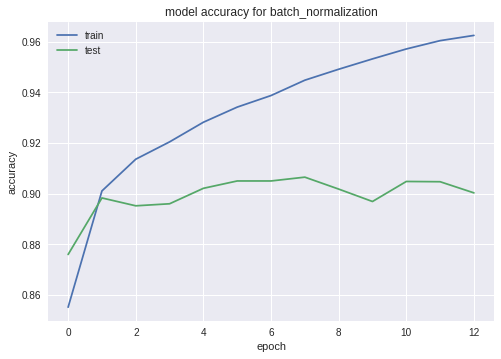

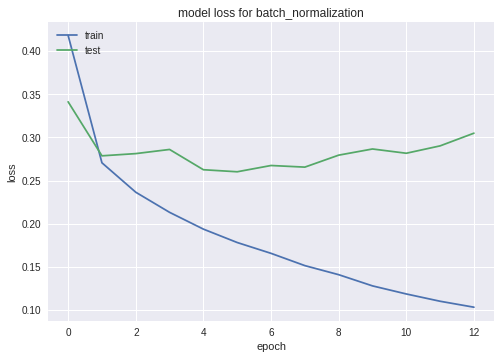

Model saved into: training_batch_normalization/cp.ckpt


In [0]:
# train type_2 - batch_normalization
checkpoint_path_type_2 = train_type(type_2, train_data, train_labels, test_data, test_labels)
print("Model saved into: {}".format(checkpoint_path_type_2))

In [0]:
# test type_2
test_type(type_2, test_data, test_labels, checkpoint_path_type_2)

10000/10000 [==============================] - 1s 119us/step
Restored model, accuracy: 90.03%
------------------------Done test stage: {'batch_normalization': '0.9'}------------------------


mkdir: cannot create directory ‘training_with_dropout’: File exists
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.6783 - acc: 0.7528 - val_loss: 0.4241 - val_acc: 0.8454

Epoch 00001: saving model to training_with_dropout/cp.ckpt
Epoch 2/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.4279 - acc: 0.8490 - val_loss: 0.3616 - val_acc: 0.8659

Epoch 00002: saving model to training_with_dropout/cp.ckpt
Epoch 3/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.3703 - acc: 0.8683 - val_loss: 0.3297 - val_acc: 0.8787

Epoch 00003: saving model to training_with_dropout/cp.ckpt
Epoch 4/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.3404 - acc: 0.8789 - val_loss: 0.3177 - val_acc: 0.8836

Epoch 00004: saving model to training_with_dropout/cp.ckpt
Epoch 5/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.3195 - acc: 0

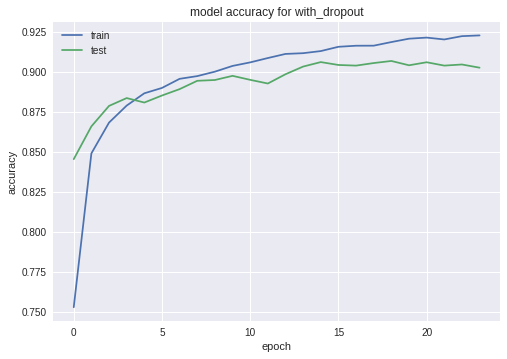

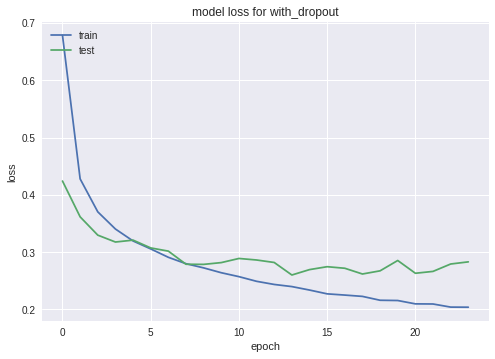

Model saved into: training_with_dropout/cp.ckpt


In [0]:
# train type_3 - with_dropout
checkpoint_path_type_3 = train_type(type_3, train_data, train_labels, test_data, test_labels)
print("Model saved into: {}".format(checkpoint_path_type_3))

In [0]:
# test type_3
test_type(type_3, test_data, test_labels, checkpoint_path_type_3)

10000/10000 [==============================] - 1s 94us/step
Restored model, accuracy: 90.26%
------------------------Done test stage: {'with_dropout': '0.50'}------------------------


mkdir: cannot create directory ‘training_without_regularization’: File exists
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.5741 - acc: 0.7914 - val_loss: 0.4173 - val_acc: 0.8510

Epoch 00001: saving model to training_without_regularization/cp.ckpt
Epoch 2/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.3665 - acc: 0.8688 - val_loss: 0.3743 - val_acc: 0.8639

Epoch 00002: saving model to training_without_regularization/cp.ckpt
Epoch 3/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.3193 - acc: 0.8840 - val_loss: 0.3283 - val_acc: 0.8818

Epoch 00003: saving model to training_without_regularization/cp.ckpt
Epoch 4/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.2894 - acc: 0.8949 - val_loss: 0.3166 - val_acc: 0.8851

Epoch 00004: saving model to training_without_regularization/cp.ckpt
Epoch 5/50
60000/60000 [====================

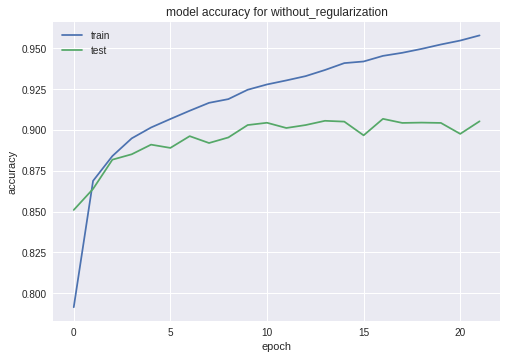

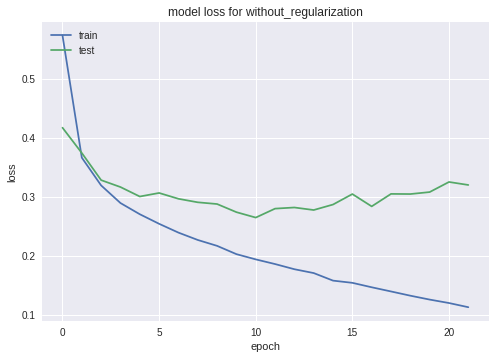

Model saved into: training_without_regularization/cp.ckpt


In [0]:
# train type_4 - without_regularization
checkpoint_path_type_4 = train_type(type_4, train_data, train_labels, test_data, test_labels)
print("Model saved into: {}".format(checkpoint_path_type_4))

In [0]:
# test type_4
test_type(type_4, test_data, test_labels, checkpoint_path_type_4)

10000/10000 [==============================] - 1s 99us/step
Restored model, accuracy: 90.53%
------------------------Done test stage: {'without_regularization': 'none'}------------------------
